# Applying the Q-Learning Algorithm to a custom environment
In the previous article, we built the standard Q-learning algorithm from scratch and implemented it as a class, `Q`. In this article we will construct a simple environment and attempt to solve it using the `Q` class.

## The Environment
A device shoots a projectile from the ground toward a target that is also at ground level. The shooter is initialized with a default initial velocity (we'll set this to 15m/s but you can change it if you want). Assuming acceleration due to gravity (g) is 9.8m/s², given a discrete target distance, determine the nearest <ins>available</ins> angle (in degrees) the projectile should be jetted at. 

Note: We also supply the target range. The standard q-learning algorithm is commonly applied to discrete state and action spaces so it is more intuitive to provide whole number target values (and thus whole number states)

Also, in this environment, there are nine angles available: 5°, 10°, 15°, 20°, 25°, 30°, 35°, 40° and 45°

How might we solve this task?

## Designing the state and action space
The environment itself will be implemented as a subclass of `Env` provided by the openai gym library. The [gym](https://www.gymlibrary.dev/content/basic_usage/) library is a popular resource used to write environments in code for agents to interact with. It provides popular environments for testing algorithms and gives you the tools to create your custom environments. 

The advantage of subclassing `Env` is that by only overriding only the necessary methods, we can still solve our custom environment using baseline algorithms from other libraries designed with the `gym.Env` class in mind.


### The State space
This is a simple environment. The states will simply be discrete values representing the target distances. Thus, I use the `Box` data structure provided in the `gym.spaces` sublibrary.  
`Box` is essentially an array that allows you to specify the lower and upper bounds for each dimension, as well as the shape and data type of the array. To understand this data structure better, consult the [documentation](https://www.gymlibrary.dev/api/spaces/#box). The documentation is also a good starting point to get familiar with other spaces provided in the `gym` universe.

The state space is defined in the `__init__` method below. Look for the line:
```
self.observation_space = Box(low=target_low, high=target_high, shape=(1,), dtype=np.int32)
```
The `__init__` method, a [dunder](https://docs.python.org/3/reference/datamodel.html#special-method-names) (or magic method, as special methods like it are called in Python), is a special method that is called when an object of a class is instantiated. By passing the values `target_low` and `target_high` as instantiation parameters to the environment object, you set the bounds of the state space. By default, the default values are 3 and 22, meaning the target values to learn the angles for range from 3m to 22m.

### The Action space
Similarly, the action space will be discrete, representing the angles to choose from. The action space will be represented by the `Discrete` data structure, which is simply a finite array that begins at 0 and ends at the provided argument for `n`. There are a couple differences between `Discrete` and `Box` such as that `Discrete` strictly contains integer values, is of dimension 1 and starts at 0. `Box` on the other hand can handle multiple data types, can be multidimensional and allows you to set different bound values for each dimension. 

_Note: I used the `Box` data structure for the state space because I wanted it to be possible to have a non-zero lower target range i.e the user can determine that the lower target range is 100m._

_The documentation for `Discrete` can be found [here](https://www.gymlibrary.dev/api/spaces/#discrete)_

I set up the action space using these lines in the `__init__` method:
```
self.action_space = Discrete(9)

self.action_to_angle = {
    0:5,
    1:10,
    2:15,
    3:20,
    4:25, 
    5:30, 
    6:35, 
    7:40,
    8:45
}
```
The attribute `action_to_angle` will serve as a lookup for converting supplied action values to angles.

## The reward scheme
Since Q-learning is a value-based algorithm and obtains its policy indirectly using an action-value table, we need to come up with a scheme to encourage choosing the right angle.  
There are maybe better ways to do this, but I decided to go with this scheme:
- calculate error as the absolute distance between the target distance and the range covered by the projectile
- create a dictionary to store the lowest errors attained at each supplied target value
- if the angle supplied during a timestep results in reducing the minimum error achieved for that target/state, the reward for that timestep is `+1`. If the error is greater, the reward is `-1`. If there is no change in the minimum error for that target value, the reward is simple, `0`.😐

This way, the policy indirectly trained will be to either reduce the error, or supply the angle that achieved the lowest error.  
  
  
Having explained the design of this environment, let's get into the code.


## Importing Libraries

In [1]:
from gym import Env
import numpy as np
from gym.spaces import Discrete, Box
import matplotlib.pyplot as plt
%matplotlib inline
import random

## Initialization
Much of the initialization code has been explained above. 

In addition, an attribute `max_repeat` is created. `max_repeat` represents the maximum number of times a target value will be repeated when `step` is called. If `max_repeat` is set to 4 and the current target is 5m, you will need to call the `step` method 4 times to move on to the next target value. This allows us perform more qtable updates for each target during an episode.

A dictionary `min_error` is created to store the minimum absolute errors attained for each target.

Also, a dict `target_to_state` is created which will be used to convert the target distance to a state value, for the qtable.

In [2]:
def __init__(self, initial_velocity=15, g=9.8, target_low=3, target_high=22, max_repeat=9):
    self.name = 'Projectile'
    # define environment bounds
    self.observation_space = Box(low=target_low, high=target_high, shape=(1,), dtype=np.int32)

    # there are 9 actions corresponding to the interval of angles from 5 to 45
    self.action_space = Discrete(9)

    # store these for easy access later
    self.n_actions = self.action_space.n
    self.n_states = target_high - target_low + 1

    self.v = initial_velocity # the default value for initial_velocity is 15m/s
    self.g = g # the default value for acceleration due to gravity is 9.8m/s²
    
    # the number of times to repeat a target value before moving on to the next
    self.max_repeat = max_repeat 

    # for action-to-angle conversion
    self.action_to_angle = {
        0:5,
        1:10,
        2:15,
        3:20,
        4:25, 
        5:30, 
        6:35, 
        7:40,
        8:45
    }

    # create a lookup of discrete state values corresponding to target distances
    self.target_to_state = {i:x for x,i in enumerate((range(target_low, target_high+1)))}

    # keep track of the lowest error attained for each target
    self.min_error = {x:np.inf for x in range(self.observation_space.low[0], self.observation_space.high[0] + 1)}

## Reset
The `reset()` method is called to reset the state of an environment. Our `reset` method 
1. creates an attribute `target_list` which is an array of all the target distances and shuffles the elements. It does this so we can keep track of the current episode's arrangement of target values. 
2. selects an initial target and removes it from `target_list`, using the `new_target()` method.
3. initializes the range of the projectile to 0, because we are yet to take an action. 
4. initializes an attribute `current_countdown` for that target. `current_countdown` starts at the value of `max_repeat` and is reduced at each time step by 1. When it eventually becomes 0, a new target will be supplied.
5. sets the `done` attribute to False. `done` becomes true when the episode is over.
4. returns the current observation using `self.get_obs()` and
 the current error calculated by `self.get_info()`

In [3]:
def new_target(self):
    # pick a target from the list of targets and remove it 
    self.target = self.target_list.pop()
    

def get_obs(self, verbose=False):
    # self.target = self.observation_space.sample() # generate random target
    self.state = self.target_to_state[self.target] # represent target as state

    # if verbose=True, return the true value of the target distance, else return 
    # its representation as a state value
    if verbose:
        return f'Target distance: {self.target}m'
    else:
        return self.state


def get_info(self, verbose=True):
    # return the number of meters by which we've missed the target
    self.error = np.abs(self.target - self.range) # absolute error

    # if verbose=True, return a full sentence, else just return the value of the error
    if verbose:
        return f'Error: {self.error:.2f}m'
    else:
        return self.error

def reset(self, verbose=True):
    # store the set of targets we can select from 
    self.target_list = list(range(self.observation_space.low[0], self.observation_space.high[0] + 1))

    random.shuffle(self.target_list) # shuffle the available targets

    self.new_target() # generate a target value
    
    self.range = 0 # the projectile is yet to be shot, so range is still 0
    self.current_countdown = self.repeat_count # start the countdown for the current target
    self.done = False

    return self.get_obs(verbose), self.get_info()

## Calculating the Range
The range (also known as horizontal distance) of the projectile is calculated using the standard formula for a projectile's range, assuming no air resistance and that the final height of the projectile is equal to its initial height:  

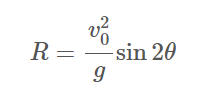  
The angle, θ, is converted to radians from degrees.

In [4]:
def calc_range(self):
    # calculate the range of the projectile using the relation v²·sin(2θ)/g
    rad = np.pi/180 * angle
    range = (v**2) * np.sin(2 * rad) / g
    return range

## Step
Calling `step` decrements `current_countdown` by 1. It takes an action value and calculates the range by calling `calc_range()`. The error is computed using `get_info()`. 
The reward is calculated using the scheme above. If the `current_countdown` is 0, a new target value is generated using `new_target` and `current_countdown` is reinitialized to the value of `max_repeat`. Once we run out of target values, `done` is set to `True`, ending the episode.

In [5]:
def step(self, action):
    # print(target_list)
    # reduce the target repeat countdown by 1
    current_countdown -= 1

    # map the action to the angle of projectile
    angle = action_to_angle[action]

    # this is the range covered by the projectile at the given angle, save it in the 
    # lookup table for current ranges
    range = calc_range()

    # evaluate error for this round
    error = get_info(verbose=False) 

    # if the error in this round is less than the history of errors for this round, the 
    # reward is set to +1. If it is higher, -1. Else, the reward is 0
    if error < min_error[target]:
        reward = 1 
        min_error[target] = error # update error range value
    elif error > min_error[target]:
        reward = -1
    elif error == min_error[target]:
        reward = 0

    if current_countdown == 0:
        if len(target_list) == 0:
            # set done to True when there are no values left in target_list and end episode
            done = True
        else:
            # else supply a new target and start the repeat counter again
            new_target()
            current_countdown = max_repeat
    
    return get_obs(), reward, done, get_info()

## Rendering
`render()` contains the logic to visualize the target, range and error, using the `numpy` library to calculate displacement values and `matplotlib` library for visualization.

In [6]:
def render(target, angle):
    v, g = 15, 9.8 # initialize velocity and acceleration due to gravity
    rad = np.pi/180 * angle
    plt.figure()
    params = {'mathtext.default': 'regular' }  # mathtext, for subscripting 0 in v0 in plot title
    tmax = (2 * v) * np.sin(rad) / g # calculate time of flight
    t = tmax*np.linspace(0,1,100) # divide time of flight into 100 uniform time steps
    x = ((v * t) * np.cos(rad)) # horizontal distance at each time step
    y = ((v * t) * np.sin(rad)) - ((0.5 * g) * (t ** 2)) # vertical distance 

    plt.plot(x, y, color='g') # plot path

    # draw line to target target (i.e desired distance) saved in `target`
    plt.axvline(x = target, ls='--', color = 'b', label = f'target: {target}m') 

    # draw projectile at final coordinates
    plt.scatter(x[-1], y[-1], color='r', marker="^", s=200)

    plt.ylim([0,10])
    plt.xlim(left=0)
    plt.title(f'$v_{0}$ = {v}m/s, θ = {angle}°, abs. error = {np.abs(x[-1]-target):.2f}m')
    plt.legend()

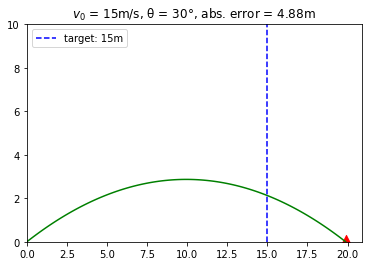

In [7]:
render(target=15, angle=30)

## Putting it all together in a class: `Projectile`

In [8]:
class Projectile(Env):
    def __init__(self, initial_velocity=15, g=9.8, target_low=3, target_high=22, max_repeat=9):
        self.name = 'Projectile'
        # define environment bounds
        self.observation_space = Box(low=target_low, high=target_high, shape=(1,), dtype=np.int32)

        # there are 9 actions corresponding to the interval of angles from 5 to 45
        self.action_space = Discrete(9)

        # store these for easy access later
        self.n_actions = self.action_space.n
        self.n_states = target_high - target_low + 1

        self.v = initial_velocity # the default value for initial_velocity is 15m/s
        self.g = g # the default value for acceleration due to gravity is 9.8m/s²
        
        # the number of times to repeat a target value before moving on to the next
        self.max_repeat = max_repeat 

        # lookup the angle values for each action
        self.action_to_angle = {
            0:5,
            1:10,
            2:15,
            3:20,
            4:25, 
            5:30, 
            6:35, 
            7:40,
            8:45
        }

        # create a lookup of discrete state values corresponding to target distances
        self.target_to_state = {i:x for x,i in enumerate((range(target_low, target_high+1)))}

        # keep track of the lowest error attained for each target
        self.min_error = {x:np.inf for x in range(self.observation_space.low[0], self.observation_space.high[0] + 1)} 


    def new_target(self):
        # pick a target from the list of targets and remove it 
        self.target = self.target_list.pop()
        

    def get_obs(self, verbose=False):
        # self.target = self.observation_space.sample() # generate random target
        self.state = self.target_to_state[self.target] # represent target as state

        # if verbose=True, return the true value of the target distance, else return 
        # its representation as a state value
        if verbose:
            return f'Target distance: {self.target}m'
        else:
            return self.state


    def get_info(self, verbose=True):
        # return the number of meters by which we've missed the target
        self.error = np.abs(self.target - self.range) # absolute error

        # if verbose=True, return a full sentence, else just return the value of the error
        if verbose:
            return f'Error: {self.error:.2f}m'
        else:
            return self.error

    def reset(self, verbose=True):
        # store the set of targets we can select from 
        self.target_list = list(range(self.observation_space.low[0], self.observation_space.high[0] + 1))

        random.shuffle(self.target_list) # shuffle the available targets
        self.new_target() # generate a target value
        self.range = 0 # the projectile is yet to be shot, so range is still 0
        self.current_countdown = self.max_repeat # start the countdown for the current target
        self.done = False

        return self.get_obs(verbose), self.get_info()


    def calc_range(self):
        # calculate the range of the projectile using the relation v²·sin(2θ)/g
        rad = np.pi/180 * self.angle
        range = (self.v**2) * np.sin(2 * rad) / self.g
        return range

    def step(self, action):
        # print(self.target_list)
        # reduce the target repeat countdown by 1
        self.current_countdown -= 1

        # map the action to the angle of projectile
        self.angle = self.action_to_angle[action]

        # this is the range covered by the projectile at the given angle, save it in the 
        # lookup table for current ranges
        self.range = self.calc_range()

        # evaluate error for this round
        self.error = self.get_info(verbose=False) 

        # if the error in this round is less than the history of errors for this round, the 
        # reward is set to +1. If it is higher, -1. Else, the reward is 0
        if self.error < self.min_error[self.target]:
            self.reward = 1 
            self.min_error[self.target] = self.error # update error range value
        elif self.error > self.min_error[self.target]:
            self.reward = -1
        elif self.error == self.min_error[self.target]:
            self.reward = 0

        if self.current_countdown == 0:
            if len(self.target_list) == 0:
                # set self.done to True when there are no values left in self.target_list and end episode
                self.done = True
            else:
                # else supply a new target and start the repeat counter again
                self.new_target()
                self.current_countdown = self.max_repeat
        
        return self.get_obs(), self.reward, self.done, self.get_info()
        

    def render(self):
        rad = np.pi/180 * self.angle
        plt.figure()
        # plt.clf()
        params = {'mathtext.default': 'regular' }  # mathtext, for subscripting 0 in v0 in plot title
        tmax = (2 * self.v) * np.sin(rad) / self.g # calculate time of flight
        t = tmax*np.linspace(0,1,100) # divide time of flight into 100 uniform time steps
        self.x = ((self.v * t) * np.cos(rad)) # horizontal distance at each time step
        self.y = ((self.v * t) * np.sin(rad)) - ((0.5 * self.g) * (t ** 2)) # vertical distance 

        plt.plot(self.x, self.y, color='g') # plot path

        # draw line to target target (i.e desired distance) saved in `self.target`
        plt.axvline(x = self.target, ls='--', color = 'b', label = f'target: {self.target}m') 

        # draw projectile at final coordinates
        plt.scatter(self.x[-1], self.y[-1], color='r', marker="^", s=200)

        plt.ylim([0,10])
        plt.xlim(left=0)
        plt.title(f'$v_{0}$ = {self.v}m/s, θ = {self.angle}°, abs. error = {np.abs(self.x[-1]-self.target):.2f}m')
        plt.legend()
    
    def __repr__(self):
        return f'''Projectile environment: 
                   Initial velocity: {self.v}m/s
                   Acceleration due to gravity: {self.g}m/s²
                   Available angles in degrees:{list(self.action_to_angle.values())}'''

# Solving this environment using the `Q` class
Using the range formula provided earlier, we can expect our q-learning algorithms to learn the closest angles. Peep the table below for an accurate calculation of the ranges covered at the provided angles

In [9]:
from tabulate import tabulate

def calc_distance(angle, v = 15, g=9.8):
    rad = np.pi/180 * angle
    distance = (v**2) * np.sin(2 * rad) / g
    return distance

angles = [5, 10, 15, 20, 25, 30, 35, 40, 45]
actual_ranges = []

for a in angles:
    actual_ranges.append([f'{a}°', calc_distance(a)])

# html_table = tabulate(actual_ranges, headers=['angle(°)', 'Range(m/s)'], tablefmt='html', numalign='center')
# print(html_table)

print('Initial velocity set to 15 m/s\n')
print(tabulate(actual_ranges, headers=['angle(°)', 'Range(m/s)'], tablefmt='rst', numalign='left'))

Initial velocity set to 15 m/s

==========  ============
angle(°)    Range(m/s)
==========  ============
5°          3.98682
10°         7.8525
15°         11.4796
20°         14.7579
25°         17.5878
30°         19.8832
35°         21.5746
40°         22.6104
45°         22.9592
==========  ============


In [10]:
html_table = tabulate(actual_ranges, headers=['angle(°)', 'Range(m/s)'], tablefmt='html', numalign='center')
print(html_table)

<table>
<thead>
<tr><th>angle(°)  </th><th style="text-align: center;"> Range(m/s) </th></tr>
</thead>
<tbody>
<tr><td>5°        </td><td style="text-align: center;">  3.98682   </td></tr>
<tr><td>10°       </td><td style="text-align: center;">   7.8525   </td></tr>
<tr><td>15°       </td><td style="text-align: center;">  11.4796   </td></tr>
<tr><td>20°       </td><td style="text-align: center;">  14.7579   </td></tr>
<tr><td>25°       </td><td style="text-align: center;">  17.5878   </td></tr>
<tr><td>30°       </td><td style="text-align: center;">  19.8832   </td></tr>
<tr><td>35°       </td><td style="text-align: center;">  21.5746   </td></tr>
<tr><td>40°       </td><td style="text-align: center;">  22.6104   </td></tr>
<tr><td>45°       </td><td style="text-align: center;">  22.9592   </td></tr>
</tbody>
</table>


In [12]:
from .script_version.q_learning import Q

100%|██████████| 5000/5000 [00:35<00:00, 140.78it/s]


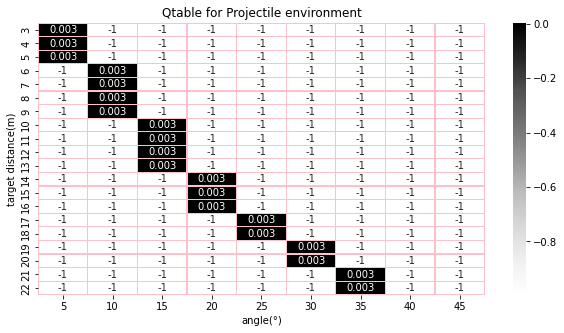

In [13]:
sim = Projectile()
sim.reset()
model = Q(sim, exploration_fraction=0.5)
model.train()
model.show(save_as='converged.png')

Compare the values supplied by the model to the actual computed values using the projectile range formula:
Initial velocity set to 15 m/s

==========  ============  
angle(°)    Range(m/s)  
==========  ============  
5°          3.98682  
10°         7.8525  
15°         11.4796  
20°         14.7579  
25°         17.5878  
30°         19.8832  
35°         21.5746  
40°         22.6104  
45°         22.9592  
==========  ============  

Congratulations! As you can see, we've successfully solved this mini problem of projectile angles with standard q-learning!